In [123]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
@import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
</style>
""")

# Model selection and descriptive statistics
In this exercise, you are given noisy data and methods to fit polynomial models multiple times to different subsets of the data. Your task is to use descriptive statistics (such as mean, variance, covariance, and correlation) to analyze the performance of these models and reflect on how well they fit the data. You will investigate how
- the models capture the underlying data 
- the fit varies across different subsets of training data
- assess how well the models perform on unseen data.

## Functions and libraries
The cell below contains functions for generating a noisy dataset and fitting a polynomial multiple times to different subsets of the generated data. More specifically:
1. `generate_polynomial(x, coeffs)`
:    - Generates ground truth data for a polynomial given the polynomial coefficients.


2. `add_gaussian_noise(y, mean, variance, num_outliers)`
:    - Adds Gaussian noise with a specified **mean** and **variance** and a number of outliers (`num_outliers`
) to simulate noisy data.


3. `fit_polynomial(x, y, M, N)`
:    - Samples  $M$  random points  $(x, y)$ from the dataset and fits an $N$-th order polynomial to the points. The function returns the fitted coefficients and the mean squared error (MSE) of the fit.


4. `iterate_fit(x, y, M, N, K)`
:    - Performs the polynomial fitting $K$ times, each time sampling  $M$  points  $(x, y)$  and fitting a polynomial of order $N$. The method returns the mean and variance of the MSE fits of each iteration, the mean of the fitted coefficients, and their covariance and correlation matrices.





In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate polynomial values
def generate_polynomial(x, coeffs):
    return np.polyval(coeffs, x)

# Function to add Gaussian noise and outliers
def add_gaussian_noise(y, mean, variance, num_outliers):
    noisy_y = y + np.random.normal(mean, np.sqrt(variance), len(y))
    
    # Add outliers
    outlier_indices = np.random.choice(range(len(noisy_y)), size=num_outliers, replace=False)
    for idx in outlier_indices:
        noisy_y[idx] += 10 * variance  # Adding large variance to simulate outliers
    
    return noisy_y

# Function to sample M points and fit a polynomial of order N
def fit_polynomial(x, y, M, N):
    # Randomly sample M points from the dataset
    indices = np.random.choice(len(x), M, replace=False)
    x_sampled = x[indices]
    y_sampled = y[indices]
    
    # Fit a polynomial of order N to the sampled points
    coeffs = np.polyfit(x_sampled, y_sampled, N)
    fitted_poly = np.poly1d(coeffs)
    
    # Calculate loss (mean squared error)
    y_fitted = fitted_poly(x_sampled)
    mse = np.mean((y_sampled - y_fitted) ** 2)
    
    return mse, coeffs


# Function to iterate K times, fit the model and compute mean/variance of errors and params
def iterate_fit(x, y, M, N, K):
    errors = []
    coeffs_list = []
    
    for _ in range(K):
        mse, coeffs = fit_polynomial(x, y, M, N)
        errors.append(mse)
        coeffs_list.append(coeffs)
    
    # Convert lists to arrays for easier manipulation
    errors = np.array(errors)
    coeffs_array = np.array(coeffs_list)
    
    # Compute statistics
    error_mean = np.mean(errors)
    error_variance = np.var(errors, ddof=1)
    coeffs_mean = np.mean(coeffs_array, axis=0)
    coeffs_covariance = np.cov(coeffs_array, rowvar=False)
    coeffs_correlation = np.corrcoef(coeffs_array, rowvar=False)
    
    return errors, coeffs_array, error_mean, error_variance, coeffs_mean, coeffs_covariance, coeffs_correlation

# Function for plotting, to prepare error bars
def prepare_error_bars(means, variances):
    std = np.sqrt(variances)
    lower_bound = np.maximum(0, np.array(means) - std)
    upper_bound = np.array(means) + std
    return [np.array(means) - lower_bound, upper_bound - np.array(means)]

## Model Fitting

---
**Task 1 (easy): Fitting the models👩‍💻**
1. Run the cell below to create the inputs `x_range`
 and the noisy outputs `y_noisy`

2. Use the `iterate_fit()`
 function to fit a 2nd-order polynomial to the generated inputs and outputs. Fit the model 100 times, sampling 20 points as the training data in each iteration.


**Hint**
Observe the output of the `iterate_fit()`
 function and ensure that all variables are created accordingly.


---

In [125]:
# Parameters for the dataset
coefficients = [1, -2, 3]  # Coefficients for the polynomial (change as needed)
x_range = np.linspace(-10, 10, 100)  # Range of x values
mean = 0  # Mean for the Gaussian noise
variance = 50  # Variance for the Gaussian noise
num_outliers = 15  # Number of outliers to introduce

# Generate noise-free polynomial dataset
y_clean = generate_polynomial(x_range, coefficients)

# Generate dataset with Gaussian noise and outliers
y_noisy = add_gaussian_noise(y_clean, mean, variance, num_outliers)

# Write your code here
K = 100
M = 20
N = 2
errors, coeffs_array, error_mean, error_variance, coeffs_mean, coeffs_covariance, coeffs_correlation = iterate_fit(x_range, y_noisy, M, N, K)


---
**Task 2 (medium): Plotting the results👩‍💻💡**
1. Run the cell below to display all fitted polynomial models and the mean fitted polynomial over the noisy data.

2. What does the variability of the fitted polynomials say about the complexity of the model?

3. Repeat the model fitting process with the same parameters as before, but on a noisy data with 5 and 15 outliers. Compare the results of having 0, 5 and 15 outliers. How do the outliers impact the variability of the individual models and the mean fitted polynomial?

4. Repeat the model fitting process with the same parameter as before, but set the number of outliers to 0 and adjust the noise variance to 150 and then to 650. How is the mean fitted polynomial affected by the increase in the noise variance? Does noise affect the model similarly to outliers? 



---

2. The the model might not be complex enough.
3. The more outlier the higher the risk of an outlier being included in the training data, thus impacting the model a lot. The more the outliers the more the model is shifted in the y-direction.
4. The higher noise variance does not actually affect the model all that much. Since the lower values are lowered and the higher values are increased the mean stays about the same.

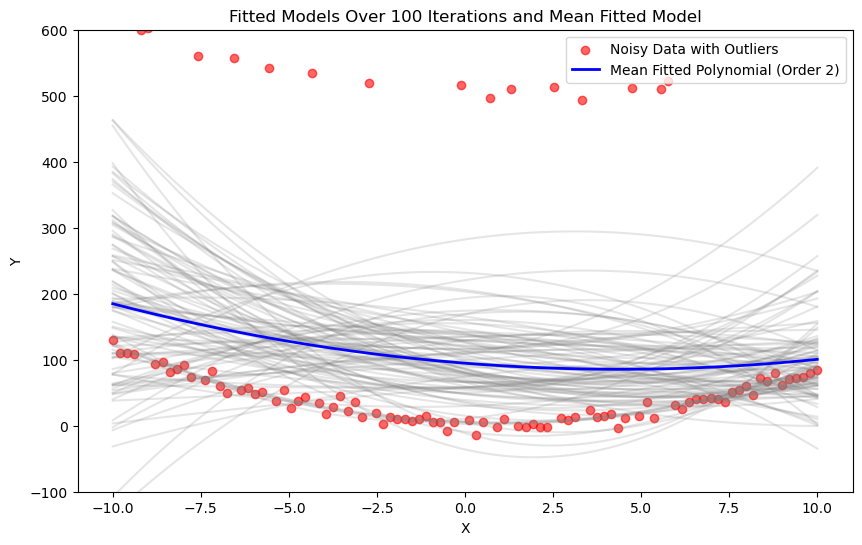

In [126]:
# Plot all fitted models and the mean fitted polynomial
plt.figure(figsize=(10, 6))
plt.scatter(x_range, y_noisy, label='Noisy Data with Outliers', color='red', alpha=0.6)

# Plot all fitted models from the iterations
for i in range(K):
    fitted_poly = np.poly1d(coeffs_array[i])
    plt.plot(x_range, fitted_poly(x_range), color='gray', alpha=0.2)

# Plot the mean fitted polynomial
fitted_mean_poly = np.poly1d(coeffs_mean)
plt.plot(x_range, fitted_mean_poly(x_range), label=f'Mean Fitted Polynomial (Order {N})', color='blue', linewidth=2)

plt.title(f"Fitted Models Over {K} Iterations and Mean Fitted Model")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.ylim(-100, 600)
plt.show()



In [127]:
# Write your reflection here

## Generalizability

---
**Task 3 (medium): Test set MSE👩‍💻💡**
The following task will modify the `fit_polynomial()`
 and the `iterate_fit()`
 functions to test the model's performance on unseen data.
1. Modify the `fit_polynomial()`
 function:    - Uncomment the line under `# Comment1`
 to create a test set and read the documentation on  [`np.setdiff1d()`
](https://numpy.org/doc/2.0/reference/generated/numpy.setdiff1d.htmls)

    - Compute `y_fitted_test`
 by applying the polynomial model to the inputs in the test set.
    - Calculate the mean squared error (MSE) for the model’s predictions on the test data and store it in `mse_test`
.


2. Modify the `iterate_fit()`
 function:    - Calculate the mean (`error_mean_test`
) and variance (`error_variance_test`
) of the test errors and let the function return these values. 


3. Generate noisy outputs with the variance of the Gaussian noise set to $100$ and no outliers. 
4. Use the generated data to fit a 2nd-order polynomial using  `iterate_fit()`
. Fit the model 100 times, sampling 20 points in each iteration.


---

In [128]:
# 1.

def fit_polynomial(x, y, M, N):
    # Randomly sample M points from the dataset for training
    indices = np.random.choice(len(x), M, replace=False)
    x_sampled = x[indices]
    y_sampled = y[indices]
    
    # Use the remaining points as the test set
    # Comment1
    test_indices = np.setdiff1d(np.arange(len(x)), indices)
    x_test = x[test_indices]
    y_test = y[test_indices]

    
    # Fit a polynomial of order N to the sampled points
    coeffs = np.polyfit(x_sampled, y_sampled, N)
    fitted_poly = np.poly1d(coeffs)
    
    # Calculate training loss (mean squared error) on the sampled points
    y_fitted_train = fitted_poly(x_sampled)
    mse_train = np.mean((y_sampled - y_fitted_train) ** 2)
    
    # Calculate test loss (mean squared error) on the remaining points (unseen data)
    y_fitted_test =  fitted_poly(x_test)
    mse_test = np.mean((y_test - y_fitted_test)**2)

    return mse_train, mse_test, coeffs


# 2. 
def iterate_fit(x, y, M, N, K):
    errors_train = []
    errors_test = []
    coeffs_list = []
    
    for _ in range(K):
        # Get both training and test errors from fit_polynomial
        mse_train, mse_test, coeffs = fit_polynomial(x, y, M, N)
        errors_train.append(mse_train)
        errors_test.append(mse_test)
        coeffs_list.append(coeffs)
    
    # Convert lists to arrays for easier manipulation
    errors_train = np.array(errors_train)
    errors_test = np.array(errors_test)
    coeffs_array = np.array(coeffs_list)
    
    # Compute statistics for training errors
    error_mean_train = np.mean(errors_train)
    error_variance_train = np.var(errors_train, ddof=1)
    
    # Compute statistics for test errors
    error_mean_test = np.mean(errors_test)
    error_variance_test = np.var(errors_test, ddof=1)

    # Compute coefficient statistics
    coeffs_mean = np.mean(coeffs_array, axis=0)
    coeffs_covariance = np.cov(coeffs_array, rowvar=False)
    coeffs_correlation = np.corrcoef(coeffs_array, rowvar=False)
    
    return (errors_train, errors_test, coeffs_array, 
            error_mean_train, error_variance_train, 
            error_mean_test, error_variance_test, 
            coeffs_mean, coeffs_covariance, coeffs_correlation)
    
# Set parameters for sampling and fitting
M = 20  # Number of samples to use
N = 2   # Order of the polynomial to fit
K = 100  # Number of iterations

# 3.

# Generate noisy outputs
# Write your solution here
#y_noisy = None # replace
y_noisy = add_gaussian_noise(y_clean, 0, 100, 0)

# 4.  

# Apply the updated iterate_fit(function)
K = 100
M = 20
N = 2
errors_train, errors_test, coeffs_array, error_mean_train, error_variance_train, error_mean_test, error_variance_test, coeffs_mean, coeffs_covariance, coeffs_correlation = iterate_fit(x_range, y_noisy, M, N, K)


---
**Task 4 (medium): Evaluation on test set💡**
Run the cell below to plot the training and testing error values for each iteration (line plot on top), along with the mean errors for both the training and testing sets (box plot on bottom). Reflect on: 
1. How does the trend of the training MSE (as seen in the line plot) compare to the trend of the test MSE over the 100 iterations?
2. What role does the variance in the test MSE play in understanding the model’s robustness on unseen data?
3. Are there any clear outliers in the boxplot for either the mean training or test MSE? How might outliers affect your understanding of the model’s performance?
4. From the boxplot, do the distributions of training and test MSE overlap significantly, or are they visibly different? What does this suggest about the generalization capability of the model?
5. Based on the line plot, do any iterations show large fluctuations in the test MSE compared to the training MSE? How does this align with what you observe in the boxplot?
6. Given the boxplot’s visualization of the MSE distributions, do the whiskers (range) for the train MSE extend further than those for the test MSE? What could explain the larger variance in train errors?


**Hint**
Take the size of the training and testing sets into consideration.


---

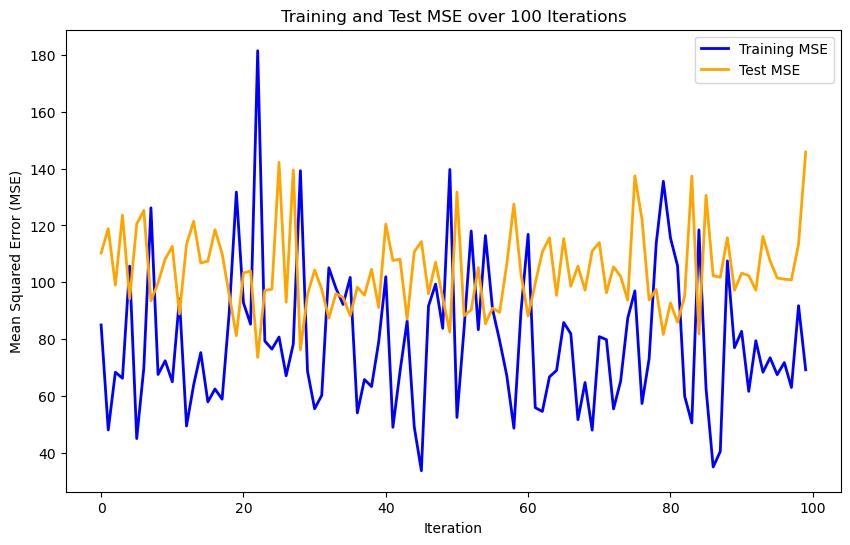

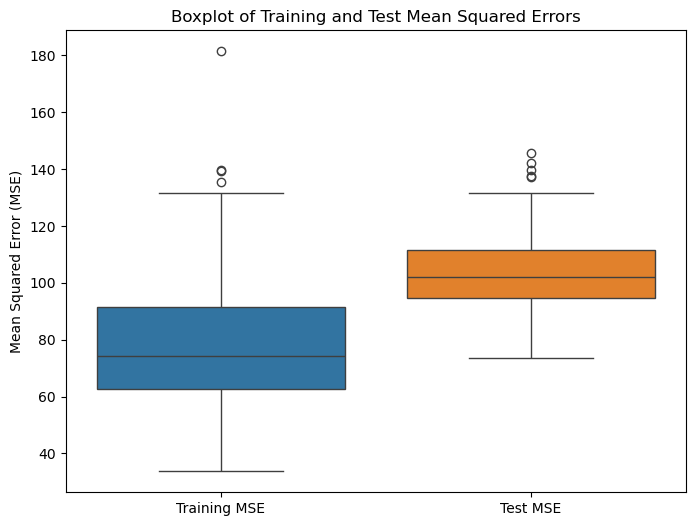

In [129]:
# Plot the training and test MSE over 100 iterations
plt.figure(figsize=(10, 6))
plt.plot(range(K), errors_train, label='Training MSE', color='blue', linewidth=2)
plt.plot(range(K), errors_test, label='Test MSE', color='orange', linewidth=2)
plt.title('Training and Test MSE over 100 Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# Boxplot of the training and test MSE
plt.figure(figsize=(8, 6))
sns.boxplot(data=[errors_train, errors_test])
plt.xticks([0, 1], ['Training MSE', 'Test MSE'])
plt.title('Boxplot of Training and Test Mean Squared Errors')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

_**Write your observations here**_
## Model complexity

---
**Task 5 (medium): Polynomial order💡**
This task experiments with fitting an increasingly more complex model to the data. The cell below performs polynomial fitting for the orders defined in the `degrees`
 array and stores the mean and variance of the training and test errors.
1. Run the cell below to visualize the mean and variance of the training and testing MSEs across different model degrees. How does increasing model complexity impact the training and testing errors?
2. Inspect the graph and identify at which degree does the model seem to overfit? Reflect on how this correspondsto the underlying function.
3. Observe how the model parameters change as the polynomial order increases. Explain the reasons for the observations on the higher-order terms.


---

1. Each degree seems to lower the training error and increase the testing error.
2. The 5th degree really seems to take off, the underlying function is a 5th degree polynomial which might make a really agressive "turn" to fit one last datapoint better which might cause an agressive delta in the y values.
3. In the beginning the coefficient seems stable but quickly begin to oscilate, this in turn affects the model by each coefficient being more sensitive to the training data.

[ 0.97554026 -2.18910436  3.99761279] 2
[ 0.0136918   0.9931632  -3.09028829  3.93497794] 3
[ 9.77787125e-04  8.63631565e-03  9.02917609e-01 -2.79325460e+00
  4.48414676e+00] 4
[ 2.26438000e-04  4.73150524e-04 -9.11646584e-03  9.50804944e-01
 -2.66960366e+00  4.35856863e+00] 5
[ 2.35516164e-05 -2.50821179e-04 -1.25588780e-03  3.19190492e-02
  9.69950873e-01 -3.21822879e+00  4.00497927e+00] 6


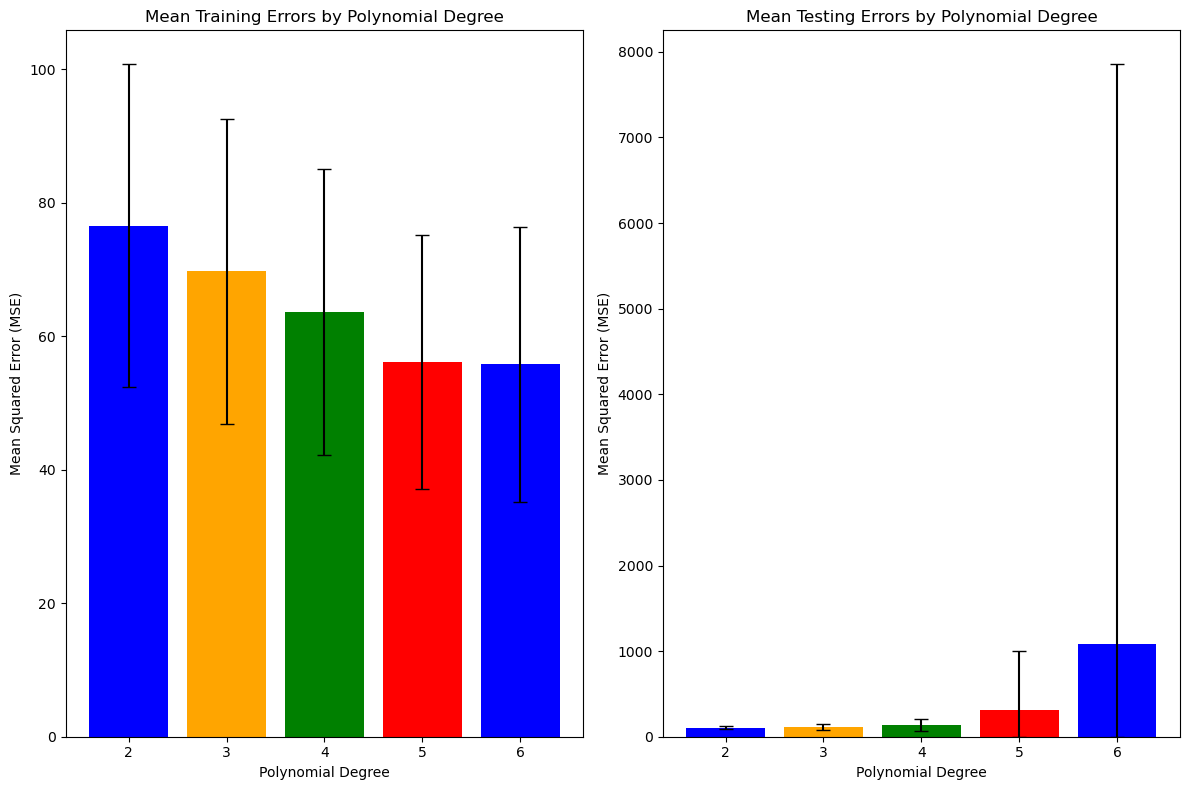

In [130]:
degrees = [2, 3, 4, 5, 6]  # 1st, 2nd, 3rd, and 4th order polynomials

# Initialize dictionaries to store the training and test error means and variances for each degree
error_means_train = {}
error_variances_train = {}
error_means_test = {}
error_variances_test = {}

# Set parameters for sampling and fitting
M = 20  # Number of samples to use
K = 100  # Number of iterations

# Loop through each polynomial degree
for N in degrees:
    
    # Perform the iterative fitting process for the current polynomial degree
    errors_train, errors_test, coeffs, error_mean_train, error_variance_train, error_mean_test, error_variance_test, coeffs_mean, _, _ = iterate_fit(x_range, y_noisy, M, N, K)
    
    print(coeffs_mean, N)
    # Store the results for training and test sets
    error_means_train[N] = error_mean_train
    error_variances_train[N] = error_variance_train
    error_means_test[N] = error_mean_test
    error_variances_test[N] = error_variance_test
    

# Data preparation
mean_training_errors = [error_means_train[d] for d in degrees]
mean_testing_errors = [error_means_test[d] for d in degrees]
training_error_bars = prepare_error_bars(mean_training_errors, [error_variances_train[d] for d in degrees])
testing_error_bars = prepare_error_bars(mean_testing_errors, [error_variances_test[d] for d in degrees])

colors = ['blue', 'orange', 'green', 'red']

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot training errors
axes[0].bar(degrees, mean_training_errors, color=colors, yerr=training_error_bars, capsize=5)
axes[0].set_xticks(degrees)
axes[0].set_title('Mean Training Errors by Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean Squared Error (MSE)')

# Plot testing errors
axes[1].bar(degrees, mean_testing_errors, color=colors, yerr=testing_error_bars, capsize=5)
axes[1].set_xticks(degrees)
axes[1].set_title('Mean Testing Errors by Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean Squared Error (MSE)')

# Adjust layout
plt.tight_layout()
plt.show()


---
**Task 6 (hard): Model parameters👩‍💻💡**
1. Run the cell below to fit a 5th-order polynomial to the data and visualize the covariance and correlation matrices of the model parameters. 
2. Which pairs of coefficients show high levels of covariance/correlation? 
3. What does the variance of the model parameters say about the performance? Could this suggest that some coefficients remain relatively stable across different samples?
4. What does the covariance of the model parameters reveal about the performance of the model? What does this reveal about model stability? Could this indicate overfitting or sensitivity to changes in the dataset?
5. What does the correlations between coefficients say about the redundancy of model parameters? Which model parameters contribute very little to the overall model?


---

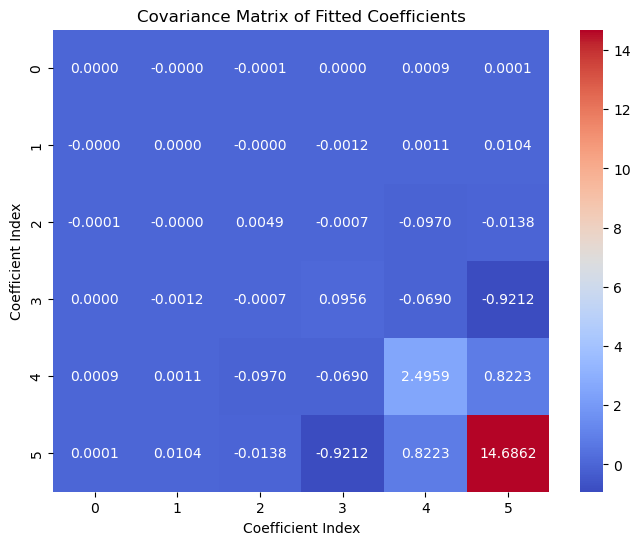

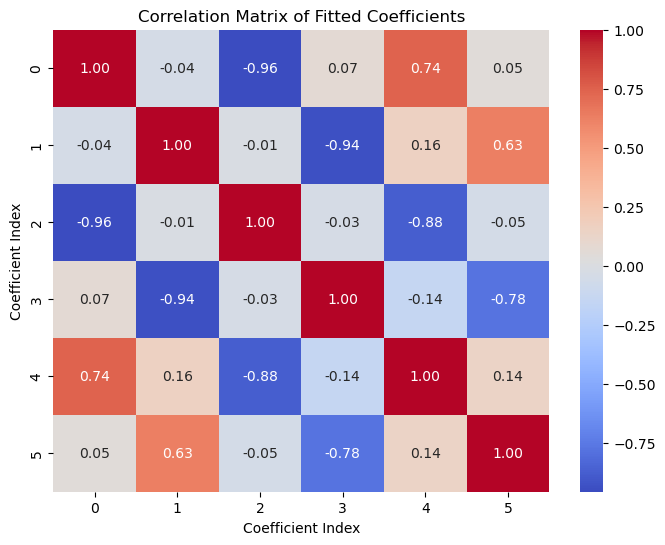

In [131]:
# Set parameters for sampling and fitting
M = 20  # Number of samples to use
K = 100  # Number of iterations
N = 5
errors_train, errors_test, coeffs_array, error_mean_train, error_variance_train, error_mean_test, error_variance_test, coeffs_mean, coeffs_covariance, coeffs_correlation = iterate_fit(x_range, y_noisy, M, N, K)

# Plot the covariance matrix of the fitted polynomial coefficients
plt.figure(figsize=(8, 6))
sns.heatmap(coeffs_covariance, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)
plt.title('Covariance Matrix of Fitted Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Index')
plt.show()

# Plot the covariance matrix of the fitted polynomial coefficients
plt.figure(figsize=(8, 6))
sns.heatmap(coeffs_correlation, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Fitted Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Index')
plt.show()

1. Run the cell below to fit a 5th-order polynomial to the data and visualize the covariance and correlation matrices of the model parameters. 
    - Done
2. Which pairs of coefficients show high levels of covariance/correlation? 
    - Covariance
        - 3,5
    - Correlation
        - 1,3
        - 0,2
        - 2,4
        - 3,5
3. What does the variance of the model parameters say about the performance? Could this suggest that some coefficients remain relatively stable across different samples?
    - The variance explodes for the 6th polynomial, the coefficients remain pretty stable up until 5 degree.
4. What does the covariance of the model parameters reveal about the performance of the model? What does this reveal about model stability? Could this indicate overfitting or sensitivity to changes in the dataset?
    - For 3 and 5 there is a very strong covariance (-0.9145), suggesting that 3 compensates for the 5th degree, indicating low stability and overfitting.
5. What does the correlations between coefficients say about the redundancy of model parameters? Which model parameters contribute very little to the overall model?
    - When we see very high correlation it means that one of the parameters are redundant, i.e. the high negative correlation between 1 and 3 shows that the 3rd degree might aswell not be there.
